## Imports 
* Please note data loading, preprocessing etc are handled in other python modules. Here is a POC (proof of concept) version for model part.

In [1]:
import warnings
import importlib
warnings.filterwarnings('ignore')
from loader import Loader
from preprocessor import Preprocessor
from spliter import Spliter 
import utils

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
#Constants
# file_name = ["data/ae.sas7bdat"]
# dict_name = ["data/meddra_dict_v21","data/meddra_dict_v22", "data/meddra_dict_v23"]
dict_name = ["data/meddra_dict_v22"]

In [4]:
loader = Loader(dict_name)

In [5]:
loader.rawdf

,Verbatim Term,LLT Name,Version
0,contact dermatitis,contact dermatitis,17.0
1,cataracts,cataracts,17.0
2,occasional lightheadedness,lightheadedness,17.0
3,occassional neurologic dizziness,dizziness,17.0
4,swollen lymph nodes bilateral neck,swollen lymph nodes,17.0
...,...,...,...
32768,right hemicolectomy,right hemicolectomy,23.0
32769,hepatic lobectomy,liver lobectomy,23.0
32770,colon biopsy,colon biopsy,23.0
32771,laparoscopic low anterior resection,lower anterior resection,23.0


In [6]:
processor = Preprocessor(loader.rawdf, loader.dict)

In [7]:
medra,raw = processor.pipe_line()

In [8]:
raw

,TERM,LLT
0,contact dermatitis,contact dermatitis
1,cataract,cataracts
2,occasional lightheadedness,lightheadedness
3,occassional neurologic dizziness,dizziness
4,swollen lymph node bilateral neck,swollen lymph nodes
...,...,...
32638,abdominal hysterectomy,abdominal hysterectomy
32639,right hemicolectomy,right hemicolectomy
32640,hepatic lobectomy,liver lobectomy
32641,colon biopsy,colon biopsy


In [9]:
X_train, X_test, Y_train, Y_test, X_ls, X_testls = Spliter(raw, medra).get_train_test()

In [10]:
X_train

0              exacerbation herpes simplex
1           painful - l foot joint big toe
2         high creatinine level 106 umol l
3            absent reflex lower extremity
4        interstitial nodular opacity lung
                       ...                
30026                        uti infection
30027                     burnt right hand
30028                       hypomagnasemia
30029                            sore limb
30030                   allergy penicillin
Name: TERM, Length: 30031, dtype: object

In [11]:
X_train.shape, X_test.shape

((30031,), (2612,))

## Load Embedding Vectors

In [12]:
%%time
# WARNING: Time consuming
word_to_index, index_to_word, word_to_vec_map = utils.read_emb_vecs('/Volumes/Yu-HD/encoder/ri-3gram-400-tsv/vocab.tsv', '/Volumes/Yu-HD/encoder/ri-3gram-400-tsv/vectors.tsv')

CPU times: user 5min 49s, sys: 16.6 s, total: 6min 6s
Wall time: 6min 12s


The word embedding vector is implemented based on paper below

@article{KHATTAK2019100057,
title = {A survey of word embeddings for clinical text},
journal = {Journal of Biomedical Informatics: X},
volume = {4},
pages = {100057},
year = {2019},
issn = {2590-177X},
doi = {https://doi.org/10.1016/j.yjbinx.2019.100057},
url = {https://www.sciencedirect.com/science/article/pii/S2590177X19300563},
author = {Faiza Khan Khattak and Serena Jeblee and ChloÃ© Pou-Prom and Mohamed Abdalla and Christopher Meaney and Frank Rudzicz},
keywords = {Word embeddings, Clinical data, Natural language processing},
abstract = {Representing words as numerical vectors based on the contexts in which they appear has become the de facto method of analyzing text with machine learning. In this paper, we provide a guide for training these representations on clinical text data, using a survey of relevant research. Specifically, we discuss different types of word representations, clinical text corpora, available pre-trained clinical word vector embeddings, intrinsic and extrinsic evaluation, applications, and limitations of these approaches. This work can be used as a blueprint for clinicians and healthcare workers who may want to incorporate clinical text features in their own models and applications.}
}

In [13]:
# Constants
CLASSES=len(set(medra['LLT']))
WINDOWS_Size=6

### Count potential spelling errors or words cannot be found in the embeddings

In [14]:
cnt = 0
for record in X_ls:
    for i in record[0:WINDOWS_Size]:
        if i not in word_to_vec_map:
            cnt += 1

In [15]:
print("There are " + str(cnt) + " number of individual training words NOT found in the word embedding vectors" )

There are 7752 number of individual training words NOT found in the word embedding vectors


In [16]:
%%time
# WARNING: Time consuming cell
from spellchecker import SpellChecker 
spell = SpellChecker()
for record in X_ls:
    for i in record[0:WINDOWS_Size]:
        if i not in word_to_vec_map:
            idx = record.index(i)
            record[idx] = spell.correction(i)
            
for record in X_testls:
    for i in record[0:WINDOWS_Size]:
        if i not in word_to_vec_map:
            idx = record.index(i)
            record[idx] = spell.correction(i)

CPU times: user 17min 26s, sys: 1.39 s, total: 17min 27s
Wall time: 17min 28s


In [17]:
cnt2 = 0
for record in X_ls:
    for i in record[0:WINDOWS_Size]:
        if i not in word_to_vec_map:
#             print(i)
            cnt2 += 1

In [18]:
print("There are " + str(cnt2) + " number of individual training words NOT found after spell correction and other corrections" )

There are 5501 number of individual training words NOT found after spell correction and other corrections


## Encode and Decode

In [19]:
import os
import pickle
import numpy as np
import pandas as pd
np.random.seed(1234)
import matplotlib.pyplot as plt

In [ ]:
# This block of codes is designed for first time construt encoder and decoder
# please note the dictionary order is random, which means model and decoder should be 1-1.


# encoder = {}
# for i, pt in enumerate(set(medra['LLT'])):
#     encoder.update({pt: i})
#     i = i + 1
# decoder = dict([(pt, i) for i, pt in encoder.items()])

# outfile = open(os.path.join('data', 'lltcoder.pkl'),'wb')
# pickle.dump(encoder,outfile)
# outfile.close()
# outfile = open(os.path.join('data', 'lltdecoder.pkl'),'wb')
# pickle.dump(decoder,outfile)
# outfile.close()

In [20]:
pwd

'/Volumes/Yu-HD/Encoder/ENCODER_ML'

In [22]:
encoder = pickle.load( open( "/Volumes/Yu-HD/Encoder/ENCODER_ML/data/lltcoder.pkl", "rb" ) )
decoder = pickle.load( open( "/Volumes/Yu-HD/Encoder/ENCODER_ML/data/lltdecoder.pkl", "rb" ) )

The following lines of code are designed to test if there are any train/test not in the target meddra version. Even though, using different version to train the model, it not makes sense to includes every version in the output since the output is version specific.

In [23]:
print("extra in test: ",[i for i in set(Y_test.tolist()) if i not in set(medra['LLT'].tolist())])

extra in test:  []


In [24]:
# Warning: This cell takes long time
# print("extra in train: ",[i for i in set(Y_train.tolist()) if i not in set(medra['LLT'].tolist())])

In [25]:
y_train =np.array([[encoder[i]] for i in Y_train])
y_test = np.array([[encoder[i]] for i in Y_test])

In [26]:
N=len(max(X_ls,key=len))
N

31

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30031,), (30031, 1), (2612,), (2612, 1))

## Embeddings

In [28]:
def emdlayer(window, textlst, dim):
    '''generate embedding layer
    random normal distribution from 0 to 0.01.
    '''
    v_tmp=[np.array([word_to_vec_map[i] 
                     if i in word_to_vec_map 
                     else (np.random.randn(dim,)*10000).astype('float32') for i in record[0:window]])
           for record in textlst]
    

    vec = []
    
    for i in range(len(textlst)):
        x1 = (np.random.randn(window-v_tmp[i].shape[0], dim)*10000).astype('float32')
        x2 = v_tmp[i]
        x = np.concatenate((x1,x2), axis=0)
        vec.append(x)
    
    vec = np.array(vec)
#     vec = np.array([np.concatenate((v_tmp[i],
#                                     (np.random.randn(window-v_tmp[i].shape[0], dim)*10000).astype('float32')),
#                                    axis=0)
#         for i in range(len(textlst))])
    return vec

In [29]:
# permutation of the input X_ls

X_ls_perm = []

for x in X_ls:
    X_ls_perm.append(np.random.permutation(x).tolist())

In [30]:
X_ls_all = [*X_ls, *X_ls_perm]

In [31]:
y_train_all = np.concatenate((y_train, y_train), axis=0)

In [32]:
%%time
# WARNING: Time consuming Cell
# X=emdlayer(WINDOWS_Size, X_ls, 400)
# X=emdlayer(WINDOWS_Size, X_ls_perm, 400)
X=emdlayer(WINDOWS_Size, X_ls_all, 400)
Xtest=emdlayer(WINDOWS_Size, X_testls, 400)
INPUT_DIM = X.shape[2]
SINGLE_ATTENTION_VECTOR = False

CPU times: user 3.94 s, sys: 1.15 s, total: 5.09 s
Wall time: 5.18 s


## Model

In [33]:
X.shape, y_train.shape, Xtest.shape, y_test.shape

((60062, 6, 400), (30031, 1), (2612, 6, 400), (2612, 1))

In [35]:
import keras.backend as K
import numpy as np
from keras.layers import concatenate, Bidirectional, Dropout, MaxPooling1D, Conv1D
from keras.layers.core import *
from keras.layers import LSTM
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [36]:
callbacks=utils.callback_()
filename = str('./model.demo')
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True, mode='max')

In [37]:
from keras.backend import manual_variable_initialization

In [38]:
manual_variable_initialization(True)

In [39]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):

    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def attention_3d_block(inputs):
#     inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, WINDOWS_Size))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(WINDOWS_Size, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    output_attention_mul = concatenate([inputs, a_probs], name='attention_mul')
    return output_attention_mul



def model_attention_applied_after_lstm():
    inputs = Input(shape=(WINDOWS_Size, INPUT_DIM,))
    drop=Dropout(0.5)(inputs)
    lstm_units1 = 128
    lstm_out, state_h, state_c = LSTM(lstm_units1, return_sequences=True, return_state=True, recurrent_regularizer=regularizers.l2(0.01))(drop)
    encoder_states = [state_h, state_c]
    decoder_out = LSTM(lstm_units1, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(lstm_out, initial_state = encoder_states)
    attention_mul = attention_3d_block(decoder_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(CLASSES, activation='softmax')(attention_mul)
    model = Model(inputs=inputs, outputs=output)
    return model


In [40]:
%%time
# from keras import optimizers
m0 = model_attention_applied_after_lstm()
rms = RMSprop(lr=0.001)
m0.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m0.summary()
h0=m0.fit([X], y_train_all, epochs=20, batch_size=128, validation_data=([Xtest], y_test), callbacks=[checkpoint])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 400)]     0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 400)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 6, 128), (No 270848      dropout[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
                                                                 lstm[0][1]                   

INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 2/20
470/470 [==============================] - 522s 1s/step - loss: 7.8343 - accuracy: 0.0880 - val_loss: 7.6051 - val_accuracy: 0.1711


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 3/20
470/470 [==============================] - 523s 1s/step - loss: 6.9420 - accuracy: 0.1515 - val_loss: 7.1547 - val_accuracy: 0.2121


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 4/20
470/470 [==============================] - 521s 1s/step - loss: 6.3009 - accuracy: 0.1981 - val_loss: 6.7548 - val_accuracy: 0.2270


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 5/20
470/470 [==============================] - 519s 1s/step - loss: 5.6732 - accuracy: 0.2430 - val_loss: 6.3850 - val_accuracy: 0.2684


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 6/20
470/470 [==============================] - 517s 1s/step - loss: 5.0600 - accuracy: 0.2877 - val_loss: 6.1426 - val_accuracy: 0.2910


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 7/20
470/470 [==============================] - 519s 1s/step - loss: 4.5653 - accuracy: 0.3312 - val_loss: 5.9198 - val_accuracy: 0.3174


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 8/20
470/470 [==============================] - 516s 1s/step - loss: 4.1172 - accuracy: 0.3681 - val_loss: 5.7000 - val_accuracy: 0.3281


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 9/20
470/470 [==============================] - 514s 1s/step - loss: 3.7461 - accuracy: 0.3985 - val_loss: 5.5868 - val_accuracy: 0.3434


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 10/20
470/470 [==============================] - 517s 1s/step - loss: 3.3901 - accuracy: 0.4350 - val_loss: 5.4770 - val_accuracy: 0.3564


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 11/20
470/470 [==============================] - 512s 1s/step - loss: 3.1183 - accuracy: 0.4625 - val_loss: 5.3336 - val_accuracy: 0.3694


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 12/20
470/470 [==============================] - 515s 1s/step - loss: 2.8758 - accuracy: 0.4847 - val_loss: 5.2435 - val_accuracy: 0.3863


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 13/20
470/470 [==============================] - 513s 1s/step - loss: 2.6606 - accuracy: 0.5103 - val_loss: 5.1905 - val_accuracy: 0.3832
Epoch 14/20
470/470 [==============================] - 515s 1s/step - loss: 2.4643 - accuracy: 0.5322 - val_loss: 5.2247 - val_accuracy: 0.3962


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 15/20
470/470 [==============================] - 510s 1s/step - loss: 2.2971 - accuracy: 0.5559 - val_loss: 5.1908 - val_accuracy: 0.3940
Epoch 16/20
470/470 [==============================] - 530s 1s/step - loss: 2.1509 - accuracy: 0.5737 - val_loss: 5.1339 - val_accuracy: 0.4005


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 17/20
470/470 [==============================] - 511s 1s/step - loss: 2.0261 - accuracy: 0.5894 - val_loss: 5.1628 - val_accuracy: 0.4058


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 18/20
470/470 [==============================] - 511s 1s/step - loss: 1.9051 - accuracy: 0.6096 - val_loss: 5.1618 - val_accuracy: 0.4054
Epoch 19/20
470/470 [==============================] - 525s 1s/step - loss: 1.8072 - accuracy: 0.6214 - val_loss: 5.1364 - val_accuracy: 0.4177


INFO:tensorflow:Assets written to: ./model.demo/assets


INFO:tensorflow:Assets written to: ./model.demo/assets


Epoch 20/20
470/470 [==============================] - 513s 1s/step - loss: 1.7380 - accuracy: 0.6320 - val_loss: 5.1729 - val_accuracy: 0.4074
CPU times: user 20h 13s, sys: 8h 6min 47s, total: 1d 4h 7min 1s
Wall time: 2h 57min 46s


The model stops converging after 16-17 epoch, the demo parameter to tune here is the units in lstm cell.  The the model becomes overfit. 

In [41]:
y_p = m0.predict(Xtest)

####obtain LLT and decode in to the dictionary term 
y_pred = [decoder[i] for i in y_p.argmax(axis=1)]
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.tolist(), y_pred)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
def plotresult(hist, title, outputfile):
	acc = hist.history['accuracy']
	val_acc = hist.history['val_accuracy']

	epochs = len(acc)
	plt.plot(range(epochs), acc, marker='.', label='acc')
	plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
	plt.legend(loc='best')
	plt.grid()
	plt.xlabel('epoch')
	plt.ylabel('acc')
	plt.title('Training/Validation: '+ title)
	plt.savefig('../images/'+outputfile)
	plt.show()

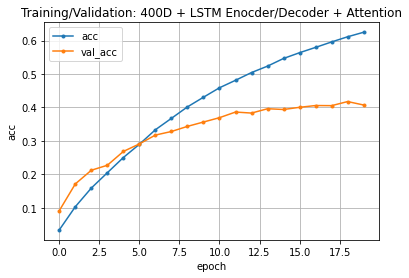

In [48]:
plotresult(h0, '400D + LSTM Enocder/Decoder + Attention', 'm0_model_attention_applied_after_lstm.png')

In [49]:
data = {"Test AE Term ":X_test, "Predicted AE LLT": y_pred, "Actual AE LLT": Y_test}
s = pd.DataFrame(data)

In [50]:
len(s.loc[s["Predicted AE LLT"] == s["Actual AE LLT"]])

1064

In [51]:
s.loc[s["Predicted AE LLT"] == s["Actual AE LLT"]]

,Test AE Term,Predicted AE LLT,Actual AE LLT
6757,fracture t12,fractured vertebra,fractured vertebra
369,chronic right leg swelling,swelling legs,swelling legs
3876,infection cyst r cheek,cyst,cyst
29822,vision blurry,blurry vision,blurry vision
19663,insopmia,insomnia,insomnia
...,...,...,...
19519,excessive sweating,excess sweating,excess sweating
7488,increase weight,weight increase,weight increase
9287,pain toe,pain toe,pain toe
15353,ache left side chest wall,chest wall pain,chest wall pain


In [52]:
# pd.set_option('display.max_rows', None)
s.loc[s["Predicted AE LLT"] != s["Actual AE LLT"]]

,Test AE Term,Predicted AE LLT,Actual AE LLT
19076,neonatal enteral feeding intollerance,feeding intolerance,enteral feeding intolerance
27702,internal iliac vein right left,iliac vein thrombosis,vein disorder
30389,chronic hypertrophy pansinusitis,knee arthritis,chronic sinusitis
573,atrial arrhythmia,arrhythmia,atrial arrhythmia
8094,left groin sensation mass swelling,ankle swelling,groin swelling
...,...,...,...
28925,pressure sore,canker sore lip,pressure sore
20831,deep venous thrombosis lower left limb,deep vein thrombosis leg,left deep vein thrombosis
23721,chronic pain syndrome grade 2,catheter site pain,chronic pain
19505,exacerbation anxiety secondary depression,anxiety aggravated,exacerbation anxiety


In [53]:
# del m0
# m0.save('my_model-2.h5')

In [54]:
K.clear_session()

## Testing data 

In [55]:
from keras.models import load_model
# np.random.seed(1234)

In [56]:
# import tensorflow as tf
# from tensorflow import keras
model = load_model('./model.demo')

In [58]:
import pandas as pd
test = pd.read_excel('/Volumes/Yu-HD/Encoder/ENCODER_ML/data/onco-AE_coding_MedDRA v22.0_KL Review_2.xlsx')

In [59]:
test = test[['Verbatim Term', 'LLT Name']]

In [60]:
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
def string_processor(x, grammer):
        """
        Method to preprocess the string, includes following process:
        1. lower case
        2. remove punctuation
        3. remove stop words
        4. stem or lemmatize the word: i.e. for grammatical reasons, d documents are going to use different forms of a
        word, such as organize, organizes, and organizing.
        For the difference between lemmatization and stemming,
        https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/
        :param grammer: "stem" or "lemma"
        :return: return a cleaned version of string (particularly the term in raw datasets, i.e. AETERM in AE)
        """
        try:
            nltk.data.find('corpora/stopwords')
            nltk.data.find('wordnet')
        except LookupError:
            # If it does not exist, the program downloads the stopwords.
            nltk.download('stopwords', quiet=True)
            nltk.download("wordnet", quiet=True)
            nltk.download('stopwords', download_dir='nltk_packages', quiet=True)
            
        sw = stopwords.words('english')
        # Stemming
        stemmer = SnowballStemmer("english")
        # lemmatization
        lemma = WordNetLemmatizer()

        if grammer == 'stem':
            x_cln = ' '.join([stemmer.stem(i) for i in re.sub(r'[^a-zA-Z]',' ', x).split() if i not in sw]).lower()
        elif grammer == 'lemma':
            x_cln = ' '.join([lemma.lemmatize(i) for i in re.sub(r'[^a-zA-Z0-9-]',' ', x).split() if i not in sw]).lower()
        elif grammer == "medra":
            x_cln = ' '.join([i.strip() for i in re.sub(r'[^a-zA-Z0-9-]',' ', x).split() if i not in sw]).lower() # keep the hyphen and numbers for the medra dictionary
            # x_cln = ' '.join([i.strip() for i in re.sub(r'[^a-zA-Z]',' ', x).split() if i not in sw]).lower())
        else:
            # x_cln = ' '.join([i.strip() for i in re.sub(r'[^\w\s]+',' ', x).split() if i not in sw]).lower()
            x_cln = ' '.join([i.strip() for i in re.sub(r'[^a-zA-Z0-9-]',' ', x).split() if i not in sw]).lower()
        return x_cln


In [61]:
test['Verbatim Term'] = test['Verbatim Term'].apply(lambda x: string_processor(x, "lemma"))
test['LLT Name'] = test['LLT Name'].apply(lambda x: string_processor(x, None))

In [62]:
no_dup = test.drop_duplicates()

In [63]:
len(test)

1313

In [64]:
len(no_dup)

1291

In [65]:
X_testls_new = [w.split() for w in test['Verbatim Term']]
len(X_testls_new)

1313

In [66]:
WINDOWS_Size=6

In [67]:
cnt3 = 0
WINDOWS_Size=6
for record in X_testls_new:
    for i in record[0:WINDOWS_Size]:
        if i not in word_to_vec_map:
            cnt3 += 1
cnt3

304

In [68]:
Xtest_new=emdlayer(WINDOWS_Size, X_testls_new, 400)

In [69]:
y_p_test = model.predict(Xtest_new)

In [70]:
y_pred_test = [decoder[i] for i in y_p_test.argmax(axis=1)]
data0 = {"Test AE Term ": test['Verbatim Term'], "Predicted AE LLT": y_pred_test, "Actual AE LLT": test['LLT Name']}
s_0 = pd.DataFrame(data0)
s0 = s_0.loc[s_0["Predicted AE LLT"] == s_0["Actual AE LLT"]]

In [71]:
s0

,Test AE Term,Predicted AE LLT,Actual AE LLT
2,bilateral le localized edema,edema lower extremities,edema lower extremities
11,abdominal bloating,abdominal bloating,abdominal bloating
12,abdominal discomfort,abdominal discomfort,abdominal discomfort
15,abdominal distension discomfort due to constip...,constipation,constipation
16,abdominal distention,abdominal distension,abdominal distension
...,...,...,...
1288,other diplopia,diplopia,diplopia
1296,pneumonia,pneumonia,pneumonia
1307,thromboembolic event pulmonary embolism,pulmonary embolism,pulmonary embolism
1311,vomiting intermittent,vomiting,vomiting


In [72]:
len(s0)

534

In [73]:
acc0 = len(s0)/len(test)
acc0

0.4067022086824067